<center>
    <h1> INF564 Diseño avanzado de algoritmos</h1>
    <h2> Tarea N°1 </h2>
    <h2> 3 de junio del 2019</h2>
    <h4> Roberto Felipe Fuentes Zenteno - 201173037-2 - roberto.fuentes@alumnos.usm.cl</h4>
</center>
<p>
</p>

## Librerias

In [228]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import ipywidgets as widgets
from numpy.random import randint
from numpy.random import seed
from numpy.random import choice
import networkx as nx

## Lectura de archivos para posiciones de autos

In [229]:
#This function stores the position of the cars of a file in a matrix of N x 2, where N is the number of cars.
def read_pos_cars(file_string):
    #arrays where x and y positions of the file are stored. 
    x_pos, y_pos = [],[]
    #read the file
    f = open(file_string, "r")
    file = f.readlines()
    #we go through the file by line storing the positions x and y
    for i in range(len(file)):
        x,y = file[i].split(" ")
        x_pos.append(int(x))
        y_pos.append(int(y))
    #cast the list into numpy array
    x_pos = np.array(x_pos)
    y_pos = np.array(y_pos)
    #return a matrix of N x 2 with the cars position
    return np.hstack((x_pos.reshape((len(x_pos),1)) , y_pos.reshape((len(y_pos),1))))

## Lectura de archivos para _request_

In [230]:
#This function reads the request file and saves them in an M x 5 array, where M is the number of requests.  
def read_request(file_string):
    #lists where we will store the x and y components of the source and destination of the request, and the instance.
    x_pos_i, y_pos_i, x_pos_f, y_pos_f, inst = [],[],[],[],[]
    #read the file
    f = open(file_string, "r")
    file = f.readlines()
    #we go through the file by line storing the positions x and y of source and destination
    for i in range(len(file)):
        origen, destino, instante = file[i].split(" - ")
        x_i, y_i = origen.split(" ")
        x_f, y_f = destino.split(" ")
        x_pos_i.append(int(x_i))
        y_pos_i.append(int(y_i))
        x_pos_f.append(int(x_f))
        y_pos_f.append(int(y_f))
        inst.append(int(instante))
    #cast the list into numpy arrays
    x_pos_i = np.array(x_pos_i)
    y_pos_i = np.array(y_pos_i)
    x_pos_f = np.array(x_pos_f)
    y_pos_f = np.array(y_pos_f)
    inst = np.array(inst)
    #return a matrix of N x 5 with the request.
    return np.hstack((x_pos_i.reshape((len(x_pos_i),1)) , y_pos_i.reshape((len(y_pos_i),1)), 
                           x_pos_f.reshape((len(x_pos_f),1)) , y_pos_f.reshape((len(y_pos_f),1)),
                           inst.reshape((len(inst),1))))

## Manhattan distance
Dado un conunto de vectores:
$$d_1(\mathbf{p}, \mathbf{q}) = \sum_{i=1}^n |p_i-q_i|$$
Donde $\mathbf{p}=(p_1,p_2,\dots,p_n)$ y $\mathbf{q}=(q_1,q_2,\dots,q_n)$

## Base
Se tabaja con una lista de autos ocupados que posee la estructura ($x,y$,costo).
* Se verifica la lista de autos ocupados: Si hay autos ocupados, estos avanzan 1 cuadra por instante de tiempo. 
* Se sacan los elementos que poseen costo $0$.
* Luego se verifica si existen request en un tiempo $i$.
    * Si existen, verificamos si hay autos disponibles para atenderlos.
    * Si tenemos mas request que autos, atendemos los request con los autos disponibles y pasamos request restantes al tiempo $i + 1$.
    * Si no tenemos autos disponibles pasamos todos los request del tiempo $i$ al $i+1$.
* Dependiendo del algoritmo (Greede, Random y Harmonic) se calculan las distancias respectivas de los autos seleccionados a cada request.
* Los autos seleccionados para atender los request del tiempo $i$ son agregados a la lista de autos ocupados y quitados de la lista de autos disponibles.

## Algoritmo greedy

In [231]:
np.random.seed(2)
ncars_ex = 20
nrequest_ex = 1
pos_cars_ex = np.array([np.random.randint(1,20,ncars_ex),np.random.randint(1,20,ncars_ex)]).reshape(ncars_ex,2)
request_ex = np.array([np.random.randint(1,20,nrequest_ex),np.random.randint(1,20,nrequest_ex)]).reshape(nrequest_ex,2)

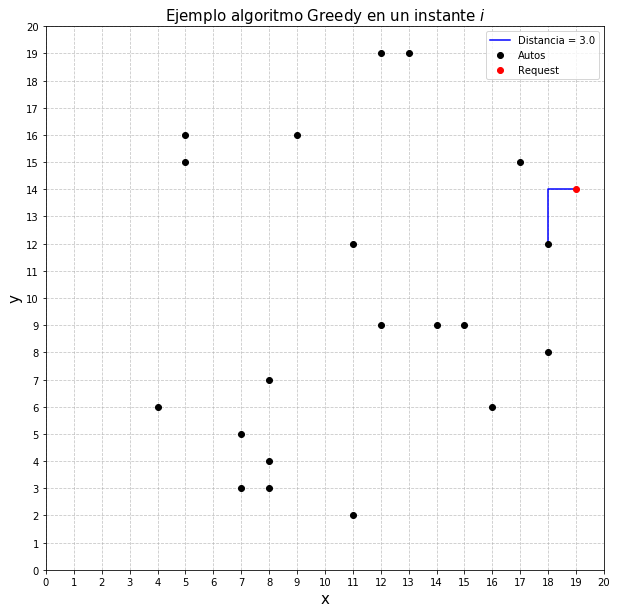

In [232]:
dista_index = np.argmin(cdist(request_ex, pos_cars_ex, metric='cityblock'))
dista = np.min(cdist(request_ex, pos_cars_ex, metric='cityblock'))

fig = plt.figure(figsize=(10,10))
f = 15
plt.step([pos_cars_ex[dista_index,0], request_ex[0,0]], [pos_cars_ex[dista_index,1], request_ex[0,1]],c='b', label="Distancia = "+str(dista))
plt.plot(pos_cars_ex[:,0], pos_cars_ex[:,1], marker='o',c='k',linestyle = 'None',label="Autos")
plt.plot(request_ex[0,0], request_ex[0,1], marker='o',c='r',linestyle = 'None', label="Request")
plt.xlabel(r'x', fontsize = f)
plt.ylabel(r'y', fontsize = f)
plt.xticks(range(0, 21, 1))
plt.yticks(range(0, 21, 1))
plt.title(r"Ejemplo algoritmo Greedy en un instante $i$", fontsize = f)
plt.grid(alpha = 0.7, linestyle ='--')
plt.legend(loc="best")
plt.show()

In [233]:
def alg_greedy(pos_cars, request, time): 
    #arrays with costs at all times
    cost = np.zeros(time)
    #array with cars that are in motion (and therefore busy) 
    #with the structure (x_car, y_car, total cost of the car).
    busy_cars = np.array([])
    #we analyze in each instance if there is activity or not. 
    #If there is, we proceed to analyze that particular request.
    for i in range(time):
        #First we analyze if there are occupied cars or not. 
        #If there are cars in motion then we make them move forward. 
        #If a car arrives at its destination (cost = 0) then it is removed from the list of busy cars. 
        if(len(busy_cars) != 0):
            cost[i] += len(busy_cars)
            cost_remain = np.where(busy_cars[:,2] > 0)[0]
            busy_cars[cost_remain,2] -= 1
            zero_elem = np.where(busy_cars[:,2] == 0)[0]
            for j in zero_elem:
                pos_cars = np.vstack((pos_cars, busy_cars[j,:2]))
            busy_cars = np.delete(busy_cars, zero_elem, axis=0) 
        #We analyze if there is a request in time i. 
        #If they do not exist we simply skip that instance and see the next one.
        list_request = np.where(request[:,4] == i)[0]
        #If there are cars available, and if the number of cars is greater than the 
        #request then we proceed to analyze. Otherwise:
        if(len(list_request) > 0):
            for j in request[list_request]:
                #- If there are no cars available, the following time is analyzed.
                if(len(pos_cars) > 0):
                    #- If there are more requests than cars then as many requests are attended as cars are available.
                    if(len(pos_cars) < len(list_request)):
                        request[list_request][len(pos_cars):,4] += 1
                        list_request = list_request[:len(pos_cars)]
                    #By all requests in one instance i we calculate the manhatan distance matrix of the 
                    #requests with all available cars.
                    matrix_distant = cdist(np.array([j[:2]]), pos_cars[:,:2], metric='cityblock')
                    #We get the index from the car with the shortest distance.
                    index_matrix_distant = np.argmin(matrix_distant,axis=1)[0]
                    #We get the shortest distance.
                    element_matrix_distant = np.min(matrix_distant,axis=1)[0]
                    #We calculate the distance from the source to the destination of the request attended.
                    distant_i_f = cdist(np.array([j[:2]]), np.array([j[2:4]]), metric='cityblock')
                    #total cost of the travel.
                    total_distance = element_matrix_distant + distant_i_f
                    #append the selected car to busy cars list.
                    if(len(busy_cars) == 0):
                        busy_cars = np.hstack((busy_cars, np.array([j[2],j[3], total_distance]))).reshape(1,3)
                    else:
                        busy_cars = np.vstack((busy_cars, np.array([j[2],j[3], total_distance])))  
                    pos_cars = np.delete(pos_cars, (index_matrix_distant), axis=0)
                #If a request was not attended to, it goes on to the next time.
                else:
                    j[4] += 1
    #return the cost list
    return cost

## Algoritmo random

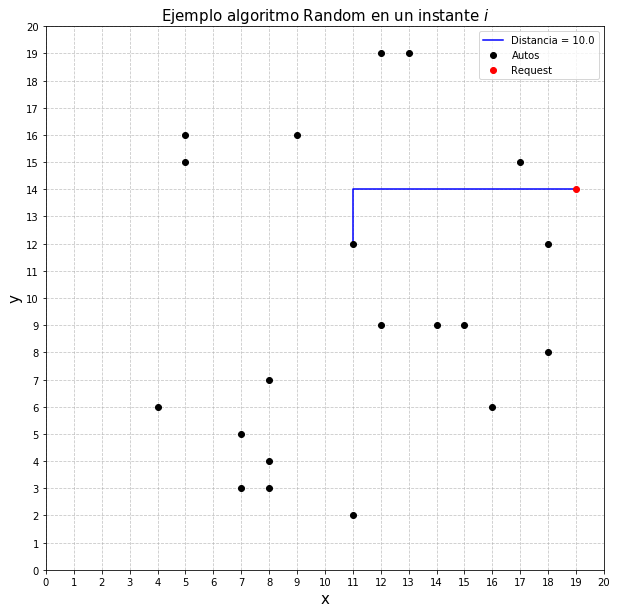

In [234]:
np.random.seed(2)
dista_index = np.random.randint(1,20,1)
dista = np.min(cdist(request_ex, pos_cars_ex[dista_index,:], metric='cityblock'))

fig = plt.figure(figsize=(10,10))
f = 15
plt.step([pos_cars_ex[dista_index,0], request_ex[0,0]], [pos_cars_ex[dista_index,1], request_ex[0,1]],c='b', label="Distancia = "+str(dista))
plt.plot(pos_cars_ex[:,0], pos_cars_ex[:,1], marker='o',c='k',linestyle = 'None',label="Autos")
plt.plot(request_ex[0,0], request_ex[0,1], marker='o',c='r',linestyle = 'None', label="Request")
plt.xlabel(r'x', fontsize = f)
plt.ylabel(r'y', fontsize = f)
plt.xticks(range(0, 21, 1))
plt.yticks(range(0, 21, 1))
plt.title(r"Ejemplo algoritmo Random en un instante $i$", fontsize = f)
plt.grid(alpha = 0.7, linestyle ='--')
plt.legend(loc="best")
plt.show()

In [235]:
#This function works the same as the greedy function, although the selection of cars is done randomly.
def alg_random(pos_cars, request, time, s): 
    seed(s)
    cost = np.zeros(time)
    busy_cars = np.array([])
    for i in range(time):
        if(len(busy_cars) != 0):
            cost[i] += len(busy_cars)
            cost_remain = np.where(busy_cars[:,2] > 0)[0]
            busy_cars[cost_remain,2] -= 1
            zero_elem = np.where(busy_cars[:,2] == 0)[0]
            for j in zero_elem:
                pos_cars = np.vstack((pos_cars, busy_cars[j,:2]))
            busy_cars = np.delete(busy_cars, zero_elem, axis=0) 
        list_request = np.where(request[:,4] == i)[0]
        if(len(list_request) > 0):
            if(len(pos_cars) > 0):
                if(len(pos_cars) < len(list_request)):
                    request[list_request][len(pos_cars):,4] += 1
                    list_request = list_request[:len(pos_cars)]
                #Here the algorithm picks a random index car from the avaible cars with no replacement.
                random_index_car = choice(len(pos_cars), len(list_request), replace=False)
                #Get the position car.
                random_car = pos_cars[random_index_car]
                #Manhatan distance from the pos car to request source.
                random_element_distant = np.sum(abs(random_car-request[list_request][:,:2]), axis = 1)
                #We calculate the distance from the source to the destination of the request attended.
                distant_i_f = np.sum(abs(request[list_request][:,:2]-request[list_request][:,2:4]), axis = 1)
                #Total distance of the travel.
                total_distant = (distant_i_f + random_element_distant).reshape(len(distant_i_f), 1)
                #append the selected car to busy cars list.
                if(len(busy_cars) == 0):
                    busy_cars = np.hstack((request[list_request][:,2:4], total_distant))
                else:
                    busy_cars = np.vstack((busy_cars, np.hstack((request[list_request][:,2:4], total_distant))))  
                pos_cars = np.delete(pos_cars, (random_index_car), axis=0)
            else:
                request[list_request][:,4] += 1
    return cost

## Algoritmo Harmonic

$$w^i = \frac{\frac{1}{d_1(\mathbf{p,q})}}{\frac{1}{\sum_{i=1}^{N_{disponibles}}d_1(\mathbf{p,q})}}$$

Distancias:  [0.0413601  0.04963211 0.0413601  0.0413601  0.02256005 0.16544038
 0.0451201  0.02363434 0.02363434 0.04963211 0.0275734  0.02481606
 0.02157918 0.03308808 0.02157918 0.16544038 0.0451201  0.03102007
 0.07090302 0.05514679]
Auto escogida:  [8]
Valor Distancia:  21.0


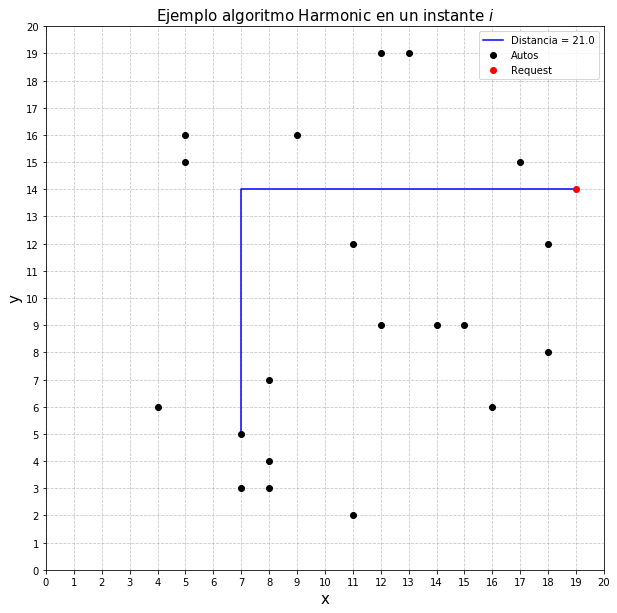

In [236]:
np.random.seed(2)

dM = cdist(pos_cars_ex, request_ex, metric='cityblock')
dM[dM == 0] = 1
weights = 1/dM / (sum(1/dM))
weights = weights.T[0]
print("Distancias: ",weights)
dista_index = choice(len(pos_cars_ex), 1, p=weights)
dista = np.min(cdist(request_ex, pos_cars_ex[dista_index,:], metric='cityblock'))
print("Auto escogida: ",dista_index)
print("Valor Distancia: ",dista)

fig = plt.figure(figsize=(10,10))
f = 15
plt.step([pos_cars_ex[dista_index,0], request_ex[0,0]], [pos_cars_ex[dista_index,1], request_ex[0,1]],c='b', label="Distancia = "+str(dista))
plt.plot(pos_cars_ex[:,0], pos_cars_ex[:,1], marker='o',c='k',linestyle = 'None',label="Autos")
plt.plot(request_ex[0,0], request_ex[0,1], marker='o',c='r',linestyle = 'None', label="Request")
plt.xlabel(r'x', fontsize = f)
plt.ylabel(r'y', fontsize = f)
plt.xticks(range(0, 21, 1))
plt.yticks(range(0, 21, 1))
plt.title(r"Ejemplo algoritmo Harmonic en un instante $i$", fontsize = f)
plt.grid(alpha = 0.7, linestyle ='--')
plt.legend(loc="best")
plt.show()

In [237]:
#This function works the same as the greedy function, although the selection of cars is done randomly with
#a distribution function based of distance of all the cars.
def alg_harmonic(pos_cars, request, time, s): 
    seed(s)
    cost = np.zeros(time)
    busy_cars = np.array([])
    for i in range(time):
        if(len(busy_cars) != 0):
            cost[i] += len(busy_cars)
            cost_remain = np.where(busy_cars[:,2] > 0)[0]
            busy_cars[cost_remain,2] -= 1
            zero_elem = np.where(busy_cars[:,2] == 0)[0]
            for j in zero_elem:
                pos_cars = np.vstack((pos_cars, busy_cars[j,:2]))
            busy_cars = np.delete(busy_cars, zero_elem, axis=0) 
        list_request = np.where(request[:,4] == i)[0]
        if(len(list_request) > 0):
            if(len(pos_cars) > 0):
                if(len(pos_cars) < len(list_request)):
                    request[list_request][len(pos_cars):,4] += 1
                    list_request = list_request[:len(pos_cars)]
                #Calculated the weights of all the distances with all request.
                dM = cdist(pos_cars, request[list_request][:,:2], metric='cityblock')
                dM[dM == 0] = 1
                weights = 1/dM / (sum(1/dM))
                weights = weights.T
                #If there is more than one request, we will select cars without replacement 
                #and with the weights calculated above.
                random_index_car = []
                for j in weights:
                    rand = choice(len(pos_cars), 1, p=j)
                    while(rand in random_index_car):
                        rand = choice(len(pos_cars), 1, p=j)
                    random_index_car.append(rand[0])
                #Get the index of all selected cars
                random_index_car = np.array(random_index_car)
                #Get the cars position
                random_car = pos_cars[random_index_car]
                #Calculated the manhatan distances of all selected cars
                random_element_distant = np.sum(abs(random_car-request[list_request][:,:2]), axis = 1)
                #We calculate the distance from the source to the destination of the request attended.
                distant_i_f = np.sum(abs(request[list_request][:,:2]-request[list_request][:,2:4]), axis = 1)
                #total distance of the travel.
                total_distant = (distant_i_f + random_element_distant).reshape(len(distant_i_f), 1)
                if(len(busy_cars) == 0):
                    busy_cars = np.hstack((request[list_request][:,2:4], total_distant))
                else:
                    busy_cars = np.vstack((busy_cars, np.hstack((request[list_request][:,2:4], total_distant))))  
                pos_cars = np.delete(pos_cars, (random_index_car), axis=0)
            else:
                request[list_request][:,4] += 1
    return cost

## Cálculo de cada algoritmo

In [238]:
def write_results(pc_option, r_option, method, lista):
    f= open(method +"_"+ pc_option.split(".")[0]+"_"+ r_option.split(".")[0],"w+")
    lista = np.cumsum(lista)
    for i in range(len(lista)):
        f.write(str(i) + " " + str(lista[i]) + "\n")
    f.close() 

In [239]:
#function that receives pc_option(position car option), r_option (request option),
#total time and instance, and executes the 3 algorithms with the autos file and request selected.
def set_cost_array(pc_option, r_option, time, s):
    #depending on the pc_option a file of cars is read and stored.
    if(pc_option == 1):
        pc_option = "manana.dat"
    elif(pc_option == 2):
        pc_option = "tarde.dat"
    elif(pc_option == 3):
        pc_option = "noche.dat"
    #depending on r_request a file of request is read and stored.
    if(r_option == 1):
        r_option = "requests_1.dat"
    elif(r_option == 2):
        r_option = "requests_2.dat"
    elif(r_option == 3):
        r_option = "requests_3.dat"
    #The algorithms are executed with the read files
    pos_cars = read_pos_cars(pc_option)
    request = read_request(r_option)
    
    g = alg_greedy(pos_cars, request, time)
    r = alg_random(pos_cars, request, time, s)
    h = alg_harmonic(pos_cars, request, time, s)
    
    write_results(pc_option, r_option, "greedy", g)
    write_results(pc_option, r_option, "random", r)
    write_results(pc_option, r_option, "harmonic", h)
    
    #return greedy, random and harmonic algoritms 
    return g, r, h

In [240]:
#parameters
s = 4
time = 12000

In [241]:
#request 1
m_r1_g, m_r1_r, m_r1_h  = set_cost_array(1, 1, time, s)
t_r1_g, t_r1_r, t_r1_h  = set_cost_array(2, 1, time, s)
n_r1_g, n_r1_r, n_r1_h  = set_cost_array(3, 1, time, s)

#request 2
m_r2_g, m_r2_r, m_r2_h  = set_cost_array(1, 2, time, s)
t_r2_g, t_r2_r, t_r2_h  = set_cost_array(2, 2, time, s)
n_r2_g, n_r2_r, n_r2_h  = set_cost_array(3, 2, time, s)

#request 3
m_r3_g, m_r3_r, m_r3_h  = set_cost_array(1, 3, time, s)
t_r3_g, t_r3_r, t_r3_h  = set_cost_array(2, 3, time, s)
n_r3_g, n_r3_r, n_r3_h  = set_cost_array(3, 3, time, s)

In [242]:
#cost of 3 algorithms with all request and all posotion cars files.
costs = [m_r1_g, m_r1_r, m_r1_h, t_r1_g, t_r1_r, t_r1_h, n_r1_g, n_r1_r, n_r1_h,
         m_r2_g, m_r2_r, m_r2_h, t_r2_g, t_r2_r, t_r2_h, n_r2_g, n_r2_r, n_r2_h,
         m_r3_g, m_r3_r, m_r3_h, t_r3_g, t_r3_r, t_r3_h, n_r3_g, n_r3_r, n_r3_h]

title = ['Mañana - Request 1', 'Tarde - Request 1', 'Noche - Request 1', 
         'Mañana - Request 2', 'Tarde - Request 2', 'Noche - Request 2',
         'Mañana - Request 3', 'Tarde - Request 3', 'Noche - Request 3']

## Gráficos y comparaciones de algoritmos

In [266]:
#Function that plot the cost in any instance of time of 3 algorithms.
def plot_costs(costs, title):
    fig = plt.figure(figsize=(20, 18))
    f = 17
    fig.suptitle("Costos en cada instante de tiempo", fontsize=f+5)
    for i in range(1,10):
        plt.subplot(3, 3, i)
        plt.plot(costs[3*(i-1)], '-o', label='Costo Greedy',ms=1, c = 'r')
        plt.plot(costs[3*(i-1)+1], '-o', label='Costo Random',ms=1, c= 'b')
        plt.plot(costs[3*(i-1)+2], '-o', label='Costo Harmonic',ms=1, c = 'k')
        plt.title(title[i-1], fontsize=f)
        plt.xlabel('Iteración', fontsize=f)
        plt.ylabel('Costo', fontsize=f)
        plt.legend(loc='best')
        plt.grid(True)
    fig.tight_layout()
    fig.subplots_adjust(top=0.94)
    plt.show()

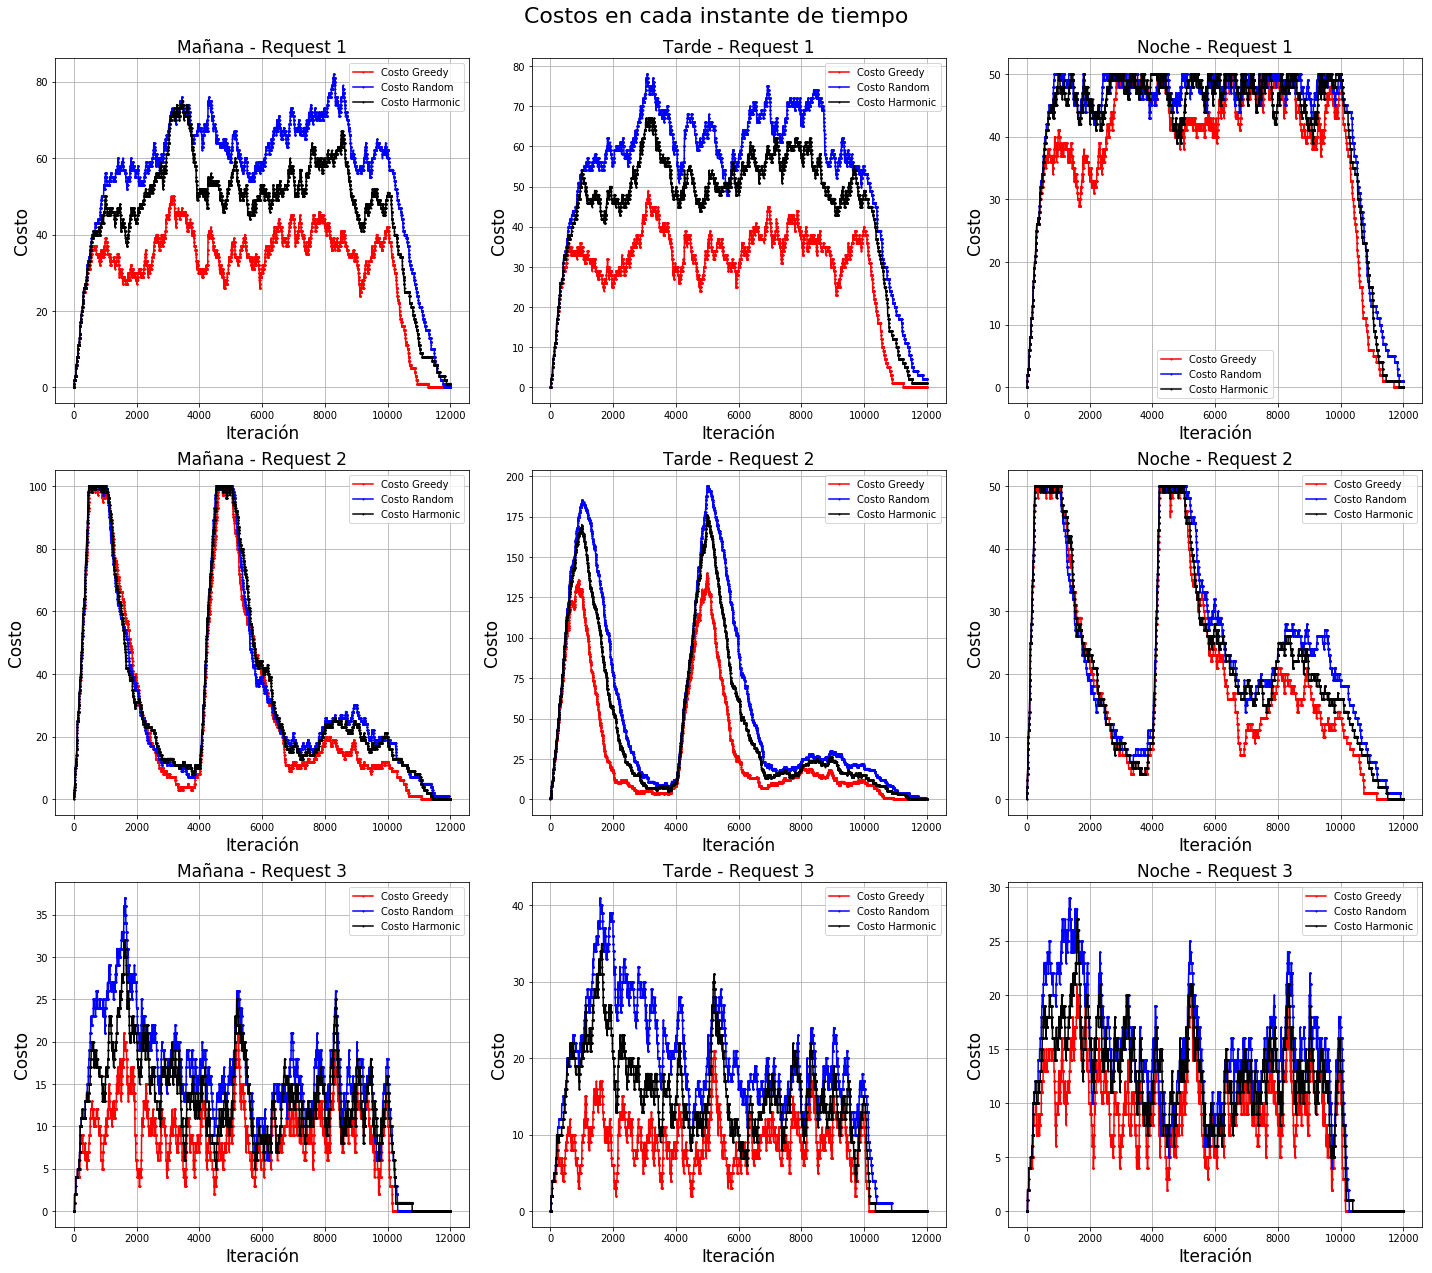

In [267]:
plot_costs(costs, title)

In [268]:
#Function that plot the cumulated cost in any instance of time of 3 algorithms.
def plot_costs_cumulated(costs, title):
    fig = plt.figure(figsize=(20, 18))
    f = 17
    fig.suptitle("Costos acumlados en cada instante de tiempo", fontsize=f+5)
    for i in range(1,10):
        plt.subplot(3, 3, i)
        plt.plot(np.cumsum(costs[3*(i-1)]), '-o', label='Costo Greedy',ms=1, c= 'r')
        plt.plot(np.cumsum(costs[3*(i-1)+1]), '-o', label='Costo Random',ms=1, c= 'b')
        plt.plot(np.cumsum(costs[3*(i-1)+2]), '-o', label='Costo Harmonic',ms=1, c = 'k')
        plt.title(title[i-1], fontsize = f)
        plt.xlabel('Iteración', fontsize = f)
        plt.ylabel('Costo acumulado', fontsize = f)
        plt.legend(loc='best')
        plt.grid(True)
    fig.tight_layout()
    fig.subplots_adjust(top=0.94)
    plt.show()

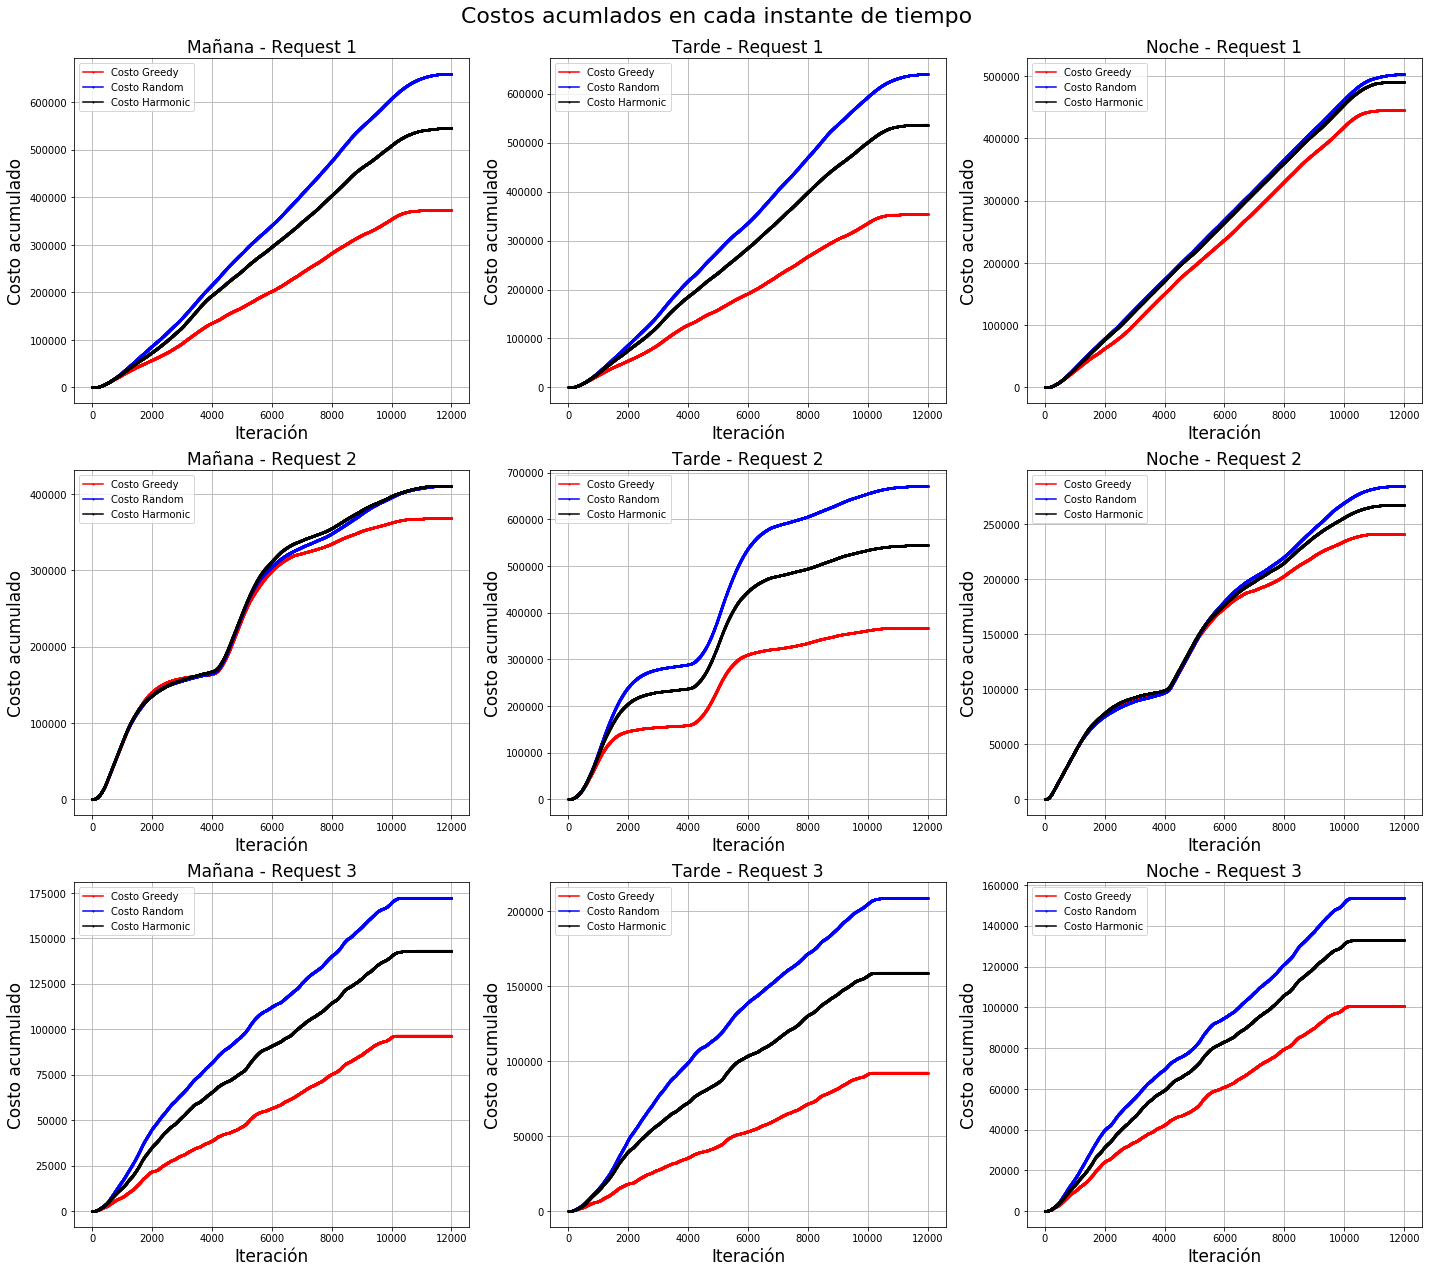

In [269]:
plot_costs_cumulated(costs, title)

In [270]:
#Function that plot the normalized cost in any instance of time of 3 algorithms.
def plot_costs_normalized(costs, title):
    fig = plt.figure(figsize=(20, 18))
    f = 17
    fig.suptitle("Costos normalizados en cada instante de tiempo", fontsize=f+5)
    for i in range(1,10):
        plt.subplot(3, 3, i)
        plt.plot(costs[3*(i-1)]/max(costs[3*(i-1)]), '-o', label='Costo Greedy',ms=1, c='r')
        plt.plot(costs[3*(i-1)+1]/max(costs[3*(i-1)+1]), '-o', label='Costo Random',ms=1, c='b')
        plt.plot(costs[3*(i-1)+2]/max(costs[3*(i-1)+2]), '-o', label='Costo Harmonic',ms=1, c='k')
        plt.title(title[i-1], fontsize = f)
        plt.xlabel('Iteración', fontsize = f)
        plt.ylabel('Costo normalizados', fontsize = f)
        plt.legend(loc='best')
        plt.grid(True)
    fig.tight_layout()
    fig.subplots_adjust(top=0.94)
    plt.show()

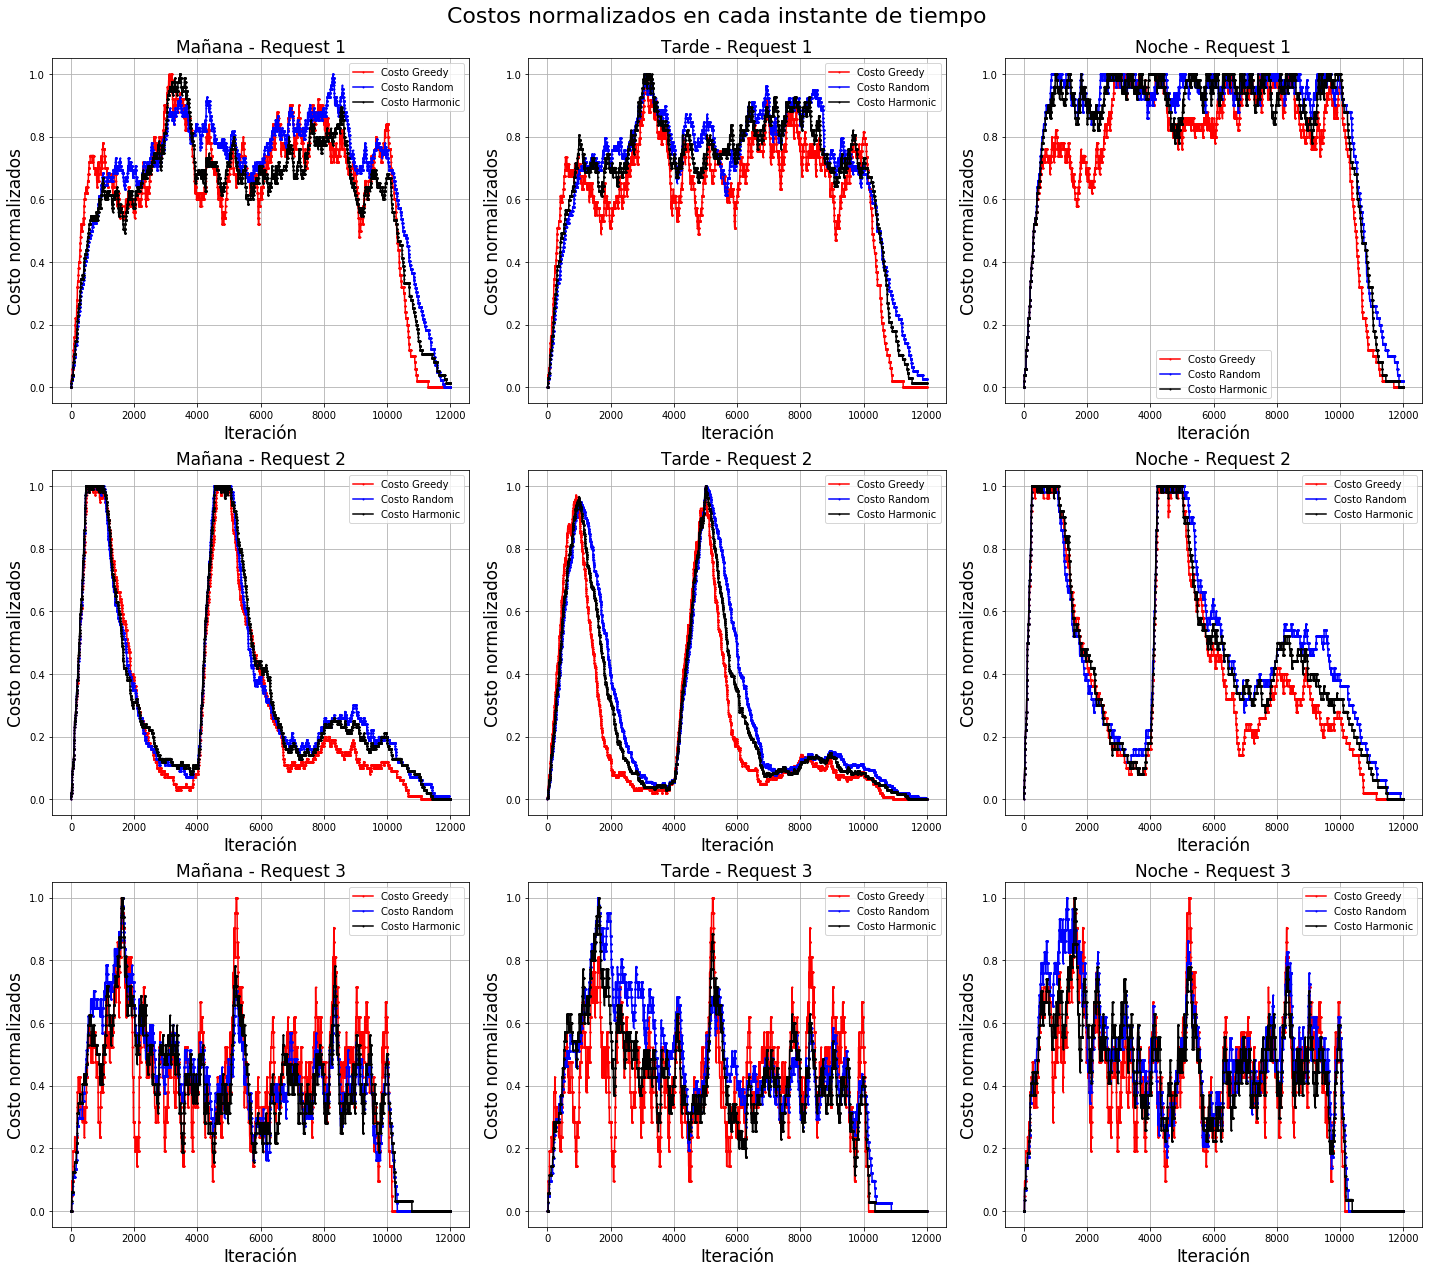

In [271]:
plot_costs_normalized(costs, title)